In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem

In [8]:
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

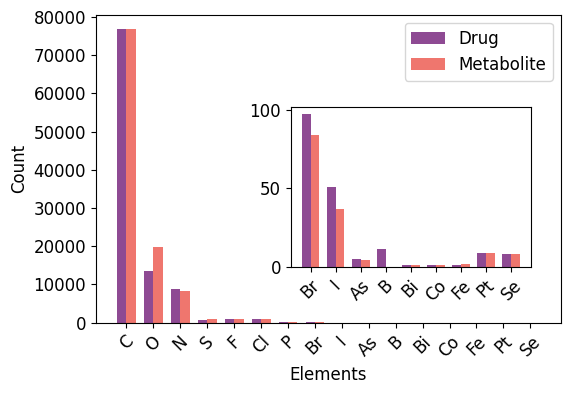

In [9]:
# Element count
def define_atoms(molecule):
    mol = Chem.MolFromSmiles(molecule)
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    atom_counts = Counter(atoms)
    return atom_counts


def analyse_atoms(data, column):
    total_atoms_count = Counter()

    for molecule in data[column]:
        atom_counts = define_atoms(molecule)
        total_atoms_count.update(atom_counts)

    return total_atoms_count


def print_atom_counts(atom_counts):
    for atom, count in atom_counts.items():
        print(f"{atom}: {count}")


def plot_histogram(parent_atom_counts, child_atom_counts, save_figure=None):
    custom_order = ['C', 'O', 'N', 'S', 'F', 'Cl', 'P', 'Br', 'I']

    all_atoms = set(list(parent_atom_counts.keys()) + list(child_atom_counts.keys()))
    remaining_atoms = sorted([atom for atom in all_atoms if atom not in custom_order])
    full_order = custom_order + remaining_atoms

    parent_counts = [parent_atom_counts.get(atom, 0) for atom in full_order]
    child_counts = [child_atom_counts.get(atom, 0) for atom in full_order]

    plt.figure(figsize=(6, 4))
    # plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
    bar_width = 0.35
    index = range(len(full_order))

    plt.bar(index, parent_counts, bar_width, label='Drug', color='#8E4A93')
    plt.bar([i + bar_width for i in index], child_counts, bar_width, label='Metabolite', color='#EF766E')

    plt.xlabel('Elements')
    plt.ylabel('Count')
    plt.xticks([i + bar_width / 2 for i in index], full_order, rotation=45)
    plt.legend()

    remaining_atoms = ['Br', 'I'] + remaining_atoms
    if remaining_atoms:
        inset_ax = plt.axes([0.45, 0.25, 0.4, 0.4])  # [left, bottom, width, height]
        inset_index = range(len(remaining_atoms))
        inset_parent_counts = [parent_atom_counts.get(atom, 0) for atom in remaining_atoms]
        inset_child_counts = [child_atom_counts.get(atom, 0) for atom in remaining_atoms]

        inset_ax.bar(inset_index, inset_parent_counts, bar_width, color='#8E4A93', label='Drug')
        inset_ax.bar([i + bar_width for i in inset_index], inset_child_counts, bar_width, color='#EF766E', label='Metabolite')

        inset_ax.set_xticks([i + bar_width / 2 for i in inset_index])
        inset_ax.set_xticklabels(remaining_atoms, rotation=45)
        # inset_ax.set_title('Remaining Atoms')

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.show()


after = "../dataset/curated_data/combined_smiles_before_filters.csv"
data = pd.read_csv(after)

parent_atom_counts = analyse_atoms(data, "parent_smiles")
child_atom_counts = analyse_atoms(data, "child_smiles")

plot_histogram(parent_atom_counts, child_atom_counts, None)

Max parent weights:  [4111.115376892007, 4111.115376892007, 1354.5674001259997, 1322.6672601919997, 1261.8624973600001]
Max child weights:  [2700.510203880001, 1343.5878012219996, 1294.6359600639996, 1277.8574119799998, 1277.8574119799998]


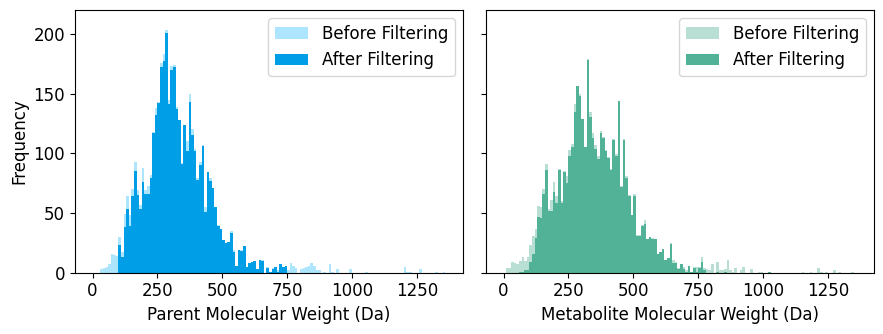

In [10]:
def molecular_weight_analysis_2(dataset):
    metabolite_weights, parent_weights = [], []

    parents = dataset["parent_smiles"]
    metabolites = dataset["child_smiles"]

    for parent, metabolite in zip(parents, metabolites):
        metabolite_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(metabolite))
        metabolite_weights.append(metabolite_weight)

        parent_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(parent))
        parent_weights.append(parent_weight)

    return metabolite_weights, parent_weights


def plot_molecular_weights_comparison(before_file, after_file, save_figure=None):
    df_before = pd.read_csv(before_file)
    df_after = pd.read_csv(after_file)

    metabolite_weights_before, parent_weights_before = molecular_weight_analysis_2(
        df_before
    )
    metabolite_weights_after, parent_weights_after = molecular_weight_analysis_2(
        df_after
    )

    fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)
    # plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

    top_five_maximums = sorted(parent_weights_before, reverse=True)[:5]
    print("Max parent weights: ", top_five_maximums)

    top_five_maximums = sorted(metabolite_weights_before, reverse=True)[:5]
    print("Max child weights: ", top_five_maximums)

    x_range = (0, 1360)
    bin_width = 10
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)

    axes[0].hist(
        parent_weights_before, bins=bins, color="#ADE5FF", label="Before Filtering"
    )
    axes[0].hist(
        parent_weights_after, bins=bins, color="#009EE7", label="After Filtering"
    )
    axes[0].set_xlabel("Parent Molecular Weight (Da)")
    axes[0].set_ylabel("Frequency")
    #axes[0].set_xlim(0, 800)
    axes[0].legend()

    axes[1].hist(
        metabolite_weights_before, bins=bins, color="#B9DFD5", label="Before Filtering"
    )
    axes[1].hist(
        metabolite_weights_after, bins=bins, color="#52B297", label="After Filtering"
    )
    axes[1].set_xlabel("Metabolite Molecular Weight (Da)")
    #axes[1].set_xlim(0, 800)
    axes[1].set_ylim(0, 220)
    axes[1].legend()

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.tight_layout()
    plt.show()


before = "../dataset/curated_data/combined_smiles_before_filters.csv"
after = "../dataset/curated_data/combined_smiles_clean.csv"
plot_molecular_weights_comparison(before, after, None)

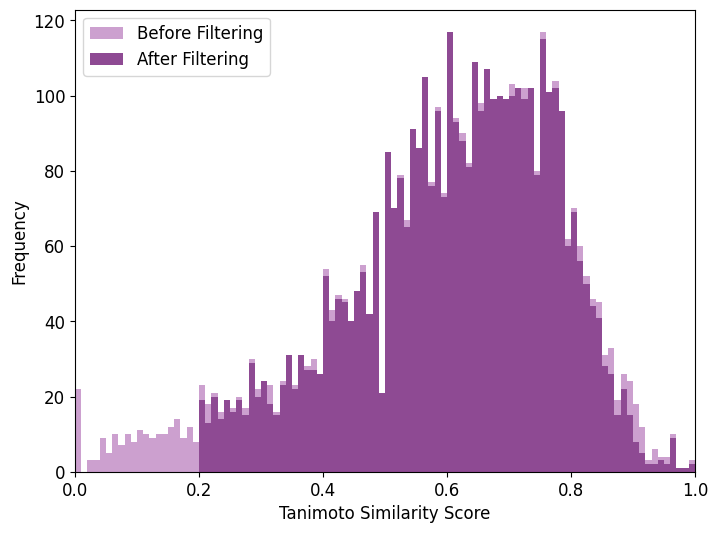

In [11]:
def fingerprint_similarity(csv_file):
    df = pd.read_csv(csv_file)
    parent_smiles = df["parent_smiles"].tolist()
    metabolite_smiles = df["child_smiles"].tolist()

    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]

    parent_fps = [
        AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024)
        for x in parent_mol
    ]
    metabolite_fps = [
        AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024)
        for x in metabolite_mol
    ]

    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        s = DataStructs.TanimotoSimilarity(parent_fps[i], metabolite_fps[i])
        fingerprint_similarities.append(s)

    return fingerprint_similarities


def plot_fingerprint_similarity(csv_file_before, csv_file_after, save_figure=None):

    plt.figure(figsize=(8, 6))
    # plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

    similarity_before = fingerprint_similarity(csv_file_before)
    similarity_after = fingerprint_similarity(csv_file_after)

    x_range = (0, 1)
    bin_width = 0.01
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)

    plt.hist(similarity_before, bins=bins, color="#CCA0CF", label="Before Filtering")
    plt.hist(similarity_after, bins=bins, color="#8E4A93", label="After Filtering")
    plt.xlabel("Tanimoto Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    # plt.ylim(0, 120)
    plt.xlim(0, 1)

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.show()


before = "../dataset/curated_data/combined_smiles_before_filters.csv"
after = "../dataset/curated_data/combined_smiles_clean.csv"
plot_fingerprint_similarity(before, after, None)

In [ ]:
def multi_boxplot(data, xlabel, ylabel, xticks, labels, location, save_figure=None, ylim=None):
    
    plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
    plt.figure(figsize=(6, 3))

    colour_scheme = ['#52B297', '#8E4A93', '#009EE7', '#EF766E']

    box_width = 0.2

    for i in range(len(data)):
        boxprops = dict(linestyle='-', linewidth=1, color='black', facecolor=colour_scheme[i])
        medianprops = dict(linestyle='--', linewidth=1, color='none')
        meanprops = dict(linestyle='-', linewidth=1, color='black')

        plt.boxplot(data[i], positions=np.arange(len(data[i])) + i * box_width, widths=box_width, patch_artist=True,
                    boxprops=boxprops, showmeans=True, meanline=True, medianprops=medianprops, meanprops=meanprops, label=labels[i])
        

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    central_positions = np.arange(len(data[0])) + (len(data) * box_width / 2) - (box_width / 2)
    plt.xticks(central_positions, xticks)
    
    if ylim is not None:
        plt.ylim(-0.005, ylim)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    if location is not None:
        plt.legend(loc=location)

    if save_figure is not None:
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{save_figure}.eps', format='eps')

    
    plt.show()

In [ ]:
# Validity comparison plot

VA_comb = [0.9763157894736842, 0.9723684210526315, 0.9078947368421053, 0.9567567567567568]

'''
Validity: 0.953 +/- 0.001
Mean number of SMILES per drug: 16.117 +/- 0.161 / 20

Total identified metabolites: 24 / 271
Total number of predictions: 2434
'''

chemVA_comb = [0.9921052631578947, 0.9828947368421053, 0.9868421052631579, 0.9918918918918919]

'''
Validity: 0.988 +/- 0.000
Mean number of SMILES per drug: 14.461 +/- 0.085 / 20

Total identified metabolites: 37 / 271
Total number of predictions: 2184
'''

chemf_comb = [0.9131578947368421, 0.9013157894736842, 0.9526315789473684, 0.9972972972972973]

'''
Validity: 0.941 +/- 0.002
Mean number of SMILES per drug: 2.247 +/- 0.298 / 20

Total identified metabolites: 0 / 271
Total number of predictions: 340
'''

comb = [chemVA_comb, VA_comb, chemf_comb]

data = [comb]

xlabel = None
ylabel = 'Validity'
xticks = ['ChemVA', 'VA', 'Chemf.']
labels = ['comb', 'rand', 'base', 'mask']

multi_boxplot(data, xlabel, ylabel, xticks, labels, None, None)

In [ ]:
# Validity variants comparison plot

chemVA_comb = [0.9921052631578947, 0.9828947368421053, 0.9868421052631579, 0.9918918918918919]

'''
Validity: 0.988 $\pm$ 0.000
Mean number of SMILES per drug: 14.461 $\pm$ 0.085 / 20

Total identified metabolites: 37 / 271
Total number of predictions: 2184
'''

chemVA_mask = [0.9907894736842106, 0.9486842105263158, 0.9578947368421052, 0.9837837837837838]

'''
Validity: 0.970 $\pm$ 0.000
Mean number of SMILES per drug: 18.273 $\pm$ 0.091 / 20

Total identified metabolites: 37 / 271
Total number of predictions: 2759
'''

chemVA_rand = [0.9960526315789474, 0.9947368421052631, 0.9736842105263158, 0.981081081081081]

'''
Validity: 0.986 $\pm$ 0.000
Mean number of SMILES per drug: 14.352 $\pm$ 0.437 / 20

Total identified metabolites: 34 / 271
Total number of predictions: 2168
'''

chemVA_base = [0.9868421052631579, 0.9592105263157895, 0.9368421052631579, 0.9621621621621622]

'''
Validity: 0.961 $\pm$ 0.000
Mean number of SMILES per drug: 17.958 $\pm$ 0.246 / 20

Total identified metabolites: 40 / 271
Total number of predictions: 2712
'''

comb = [chemVA_comb, chemVA_rand, chemVA_base, chemVA_mask]

data = [comb]

xlabel = None
ylabel = 'Validity'
xticks = ['Comb', 'Rand', 'Base', 'Mask']
# labels = ['comb', 'rand', 'base', 'mask']

multi_boxplot(data, xlabel, ylabel, xticks, labels, None, None)